In [1]:
# 라이브러리 호출
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

In [2]:
# 데이터셋 내려 받기
trainset = torchvision.datasets.FashionMNIST(
    root= '../data/', train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [3]:
# 데이터셋을 메모리로 가져오기
import torch.utils


batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [4]:
# 데이터셋 분리
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
4


In [5]:
# 이미지 데이터를 출력하기 위한 전처리
def imshow(img, title):
    # 출력할 개별 이미지의 크기 지정
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    # 이미지의 형태를 [너비, 높이, 채널]으로 지정
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [6]:
def show_batch_images(dataloader):
    # 이미지의 크기는 (4, 28, 28, 1(배치 크기, 높이, 너비, 채널))
    images, labels = next(iter(dataloader))    

    # 좌표에 이미지 픽셀을 대응시켜 그리드 형태로 출력
    img = torchvision.utils.make_grid(images)
    # imshow 함수를 사용하여 
    imshow(img, title=[str(x.item()) for x in labels])

    return images, labels

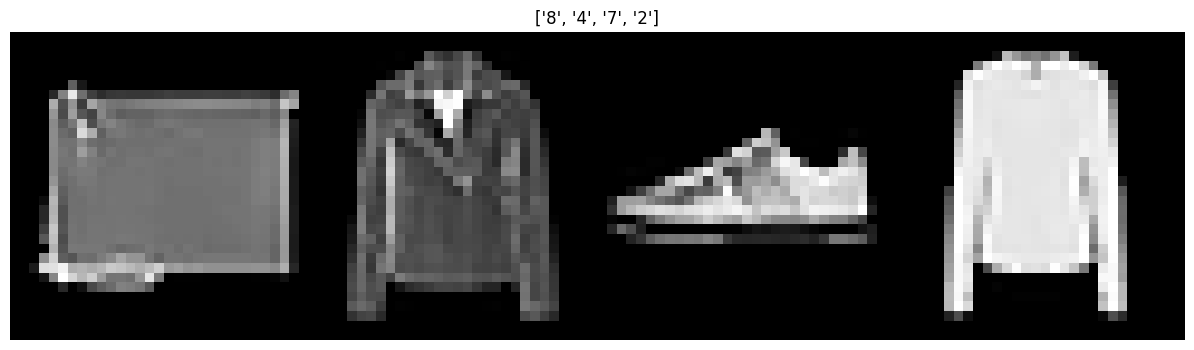

In [7]:
images, labels = show_batch_images(trainloader)

# classes = {
#     0: 'T-Shirt/Top',
#     1: 'Trouser',
#     2: 'Pullover',
#     3: 'Dress',
#     4: 'Coat',
#     5: 'Sandal',
#     6: 'Shirt',
#     7: 'Sneaker',
#     8: 'Bag',
#     9: 'Ankle Boot',
# }

In [8]:
# 배치 정규화가 적용되지 않은 네트워크
class NormalNet(nn.Module):

    def __init__(self):
        super(NormalNet, self).__init__()
        # nn.Sequential을 사용하면 forward() 함수에서 계층 별로 가독성 있게 코드 구현이 가능
        self.classifier = nn.Sequential(
            # (28, 28) 크기의 이미지로 입력은 784 (28 x 28)크기가 됨
            nn.Linear(784, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            # FashionMNIST의 클래스는 총 열 개
            nn.Linear(24, 10)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        # nn.Sequential에서 정의한 계층 호출
        x = self.classifier(x)
        return x

In [9]:
# 배치 정규화가 포함된 네트워크

class BNNet(nn.Module):
    
    def __init__(self):
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
# 배치 정규화가 적용되지 않은 모델 선언
model = NormalNet()
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [11]:
# 배치 정규화가 적용된 모델 선언
model_bn = BNNet()
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [12]:
# 데이터셋을 메모리로 불러오기
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [17]:
# 옵티마이저, 손실 함수 정의
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

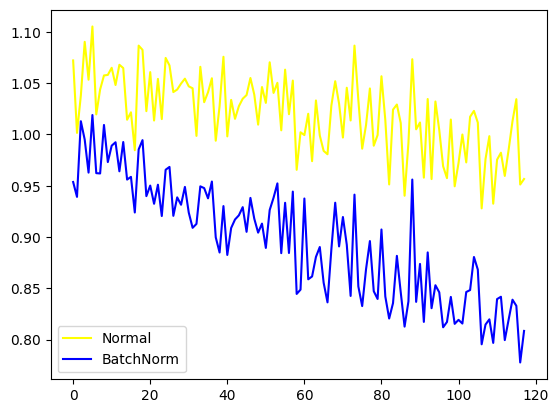

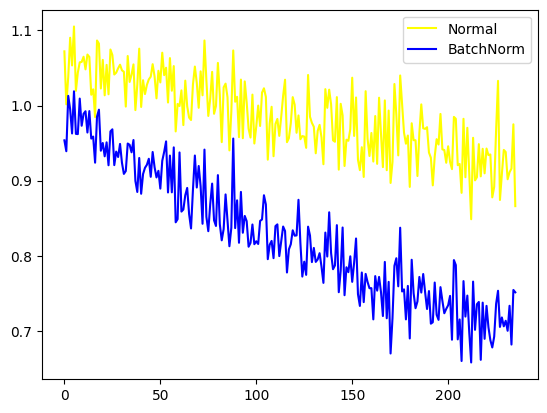

In [19]:
# 모델 학습
loss_arr, loss_bn_arr = [], []
max_epochs = 2

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # 배치 정규화가 적용되지 않은 모델 학습
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        # 배치 정규화가 적용된 모델 학습
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')
    plt.legend()
    plt.show()

In [20]:
# 데이터셋의 분포를 출력하기 위한 전처리
N, noise = 50, 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

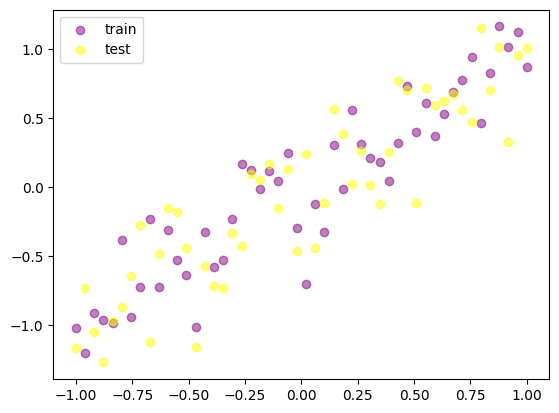

In [39]:
# 데이터 분포를 그래프로 출력
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()


In [40]:
# 드롭아웃을 위한 모델 생성
N_h = 100
# 드롭아웃이 적용되지 않은 모델
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

# 드롭아웃이 적용된 모델
model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    # 전체 20% 훈련 제외
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [41]:
# 옵티마이저와 손실 함수 지정
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

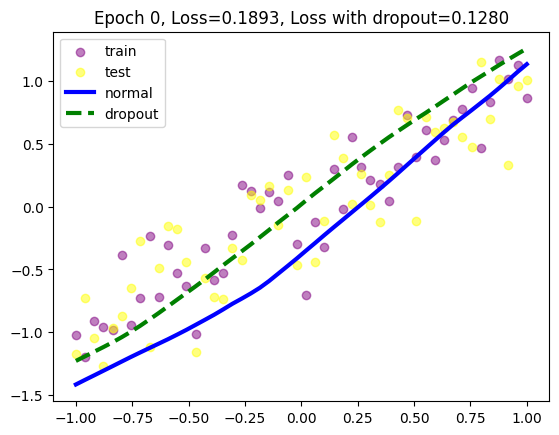

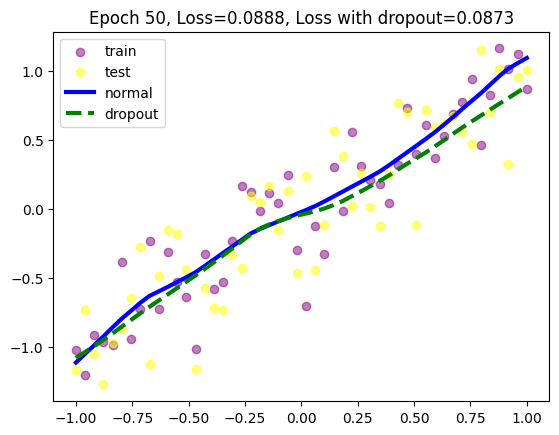

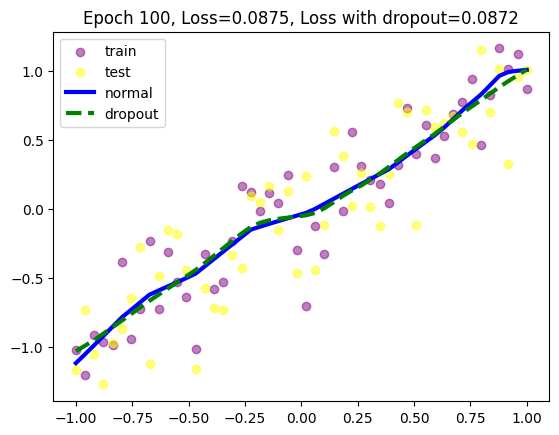

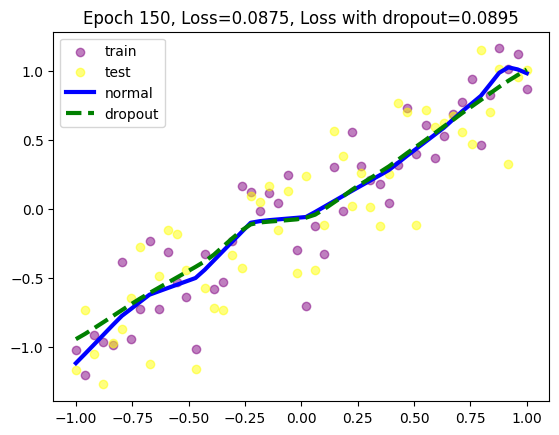

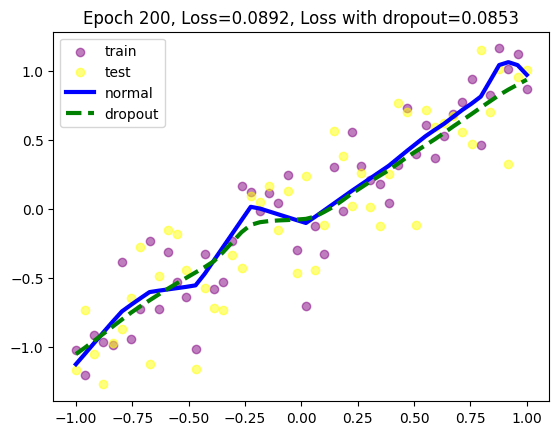

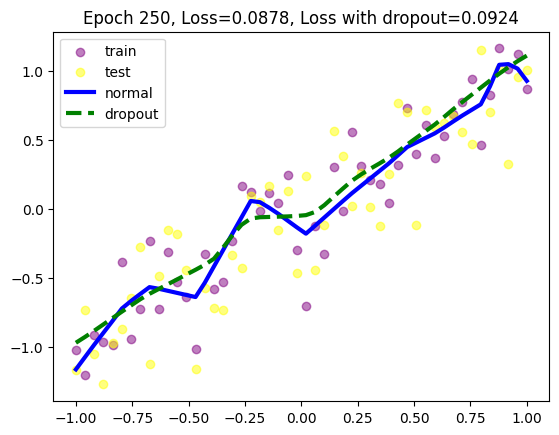

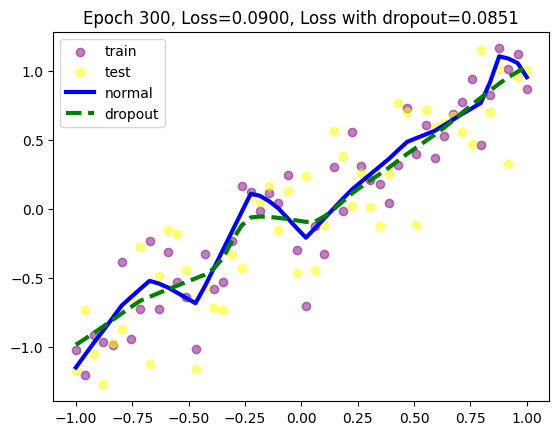

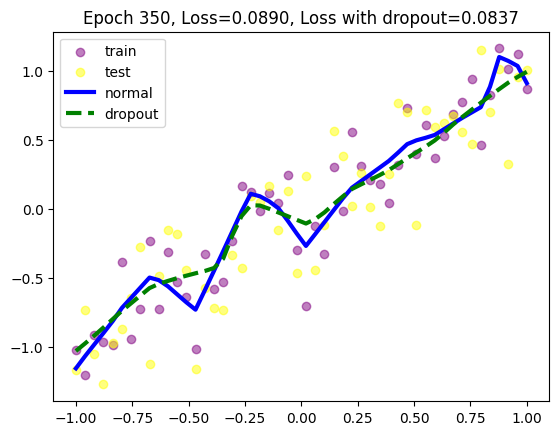

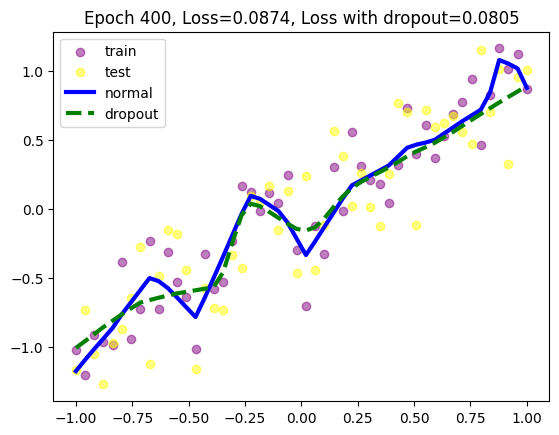

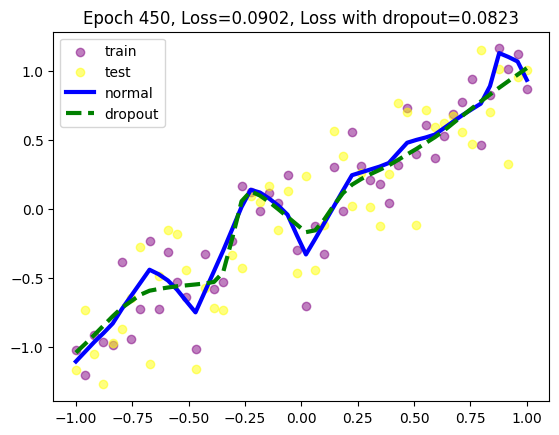

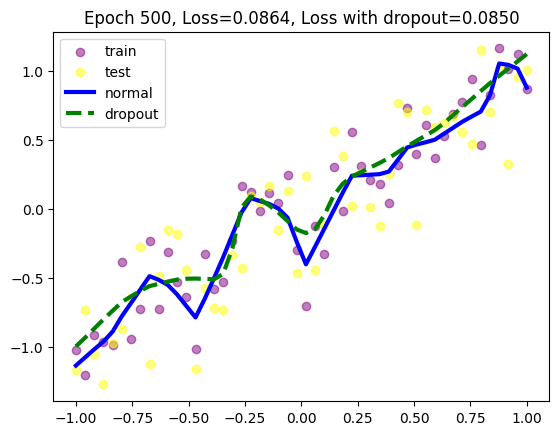

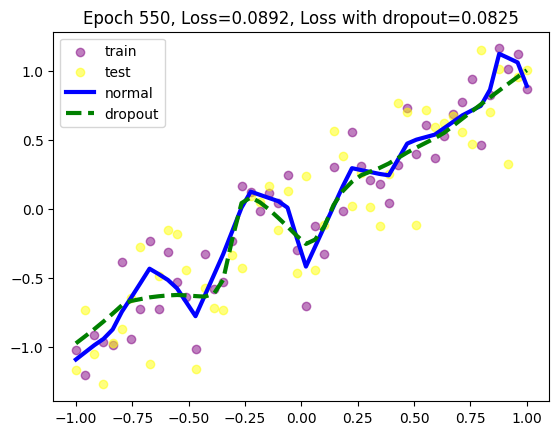

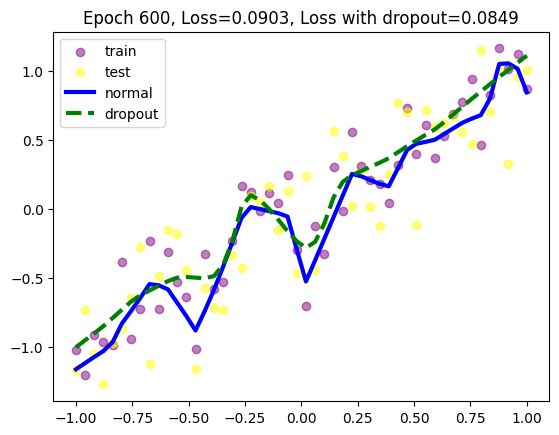

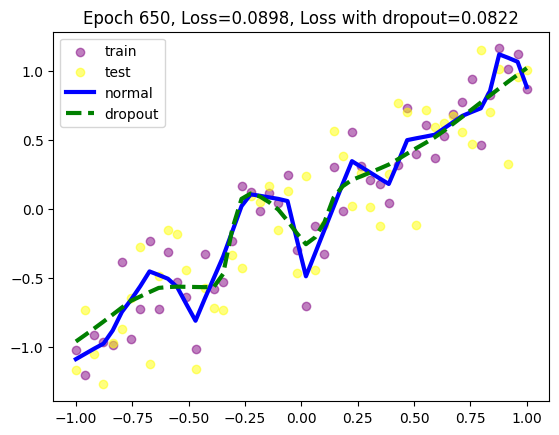

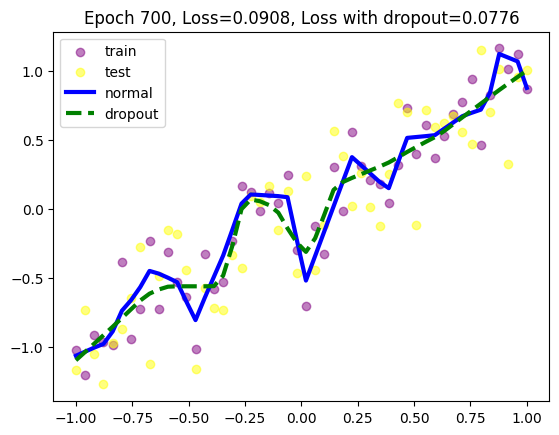

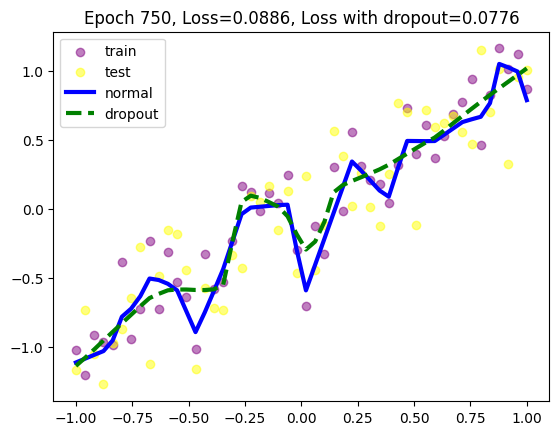

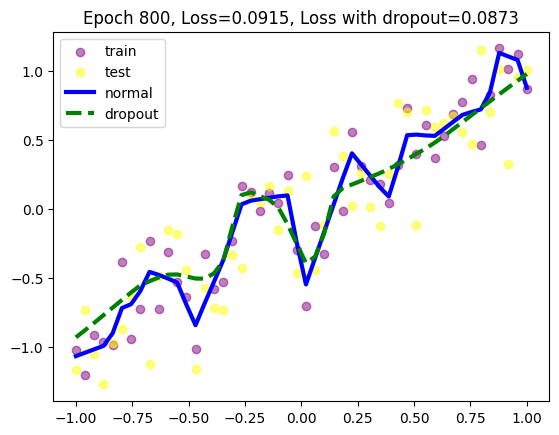

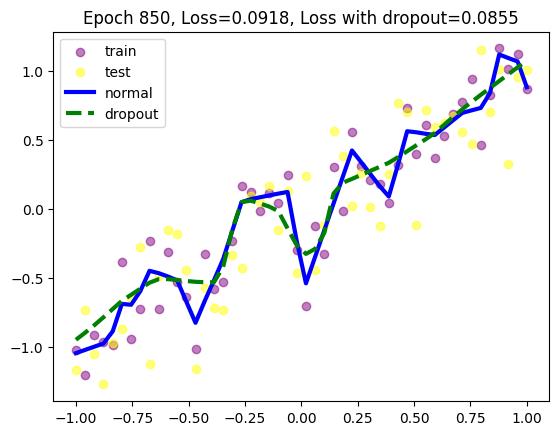

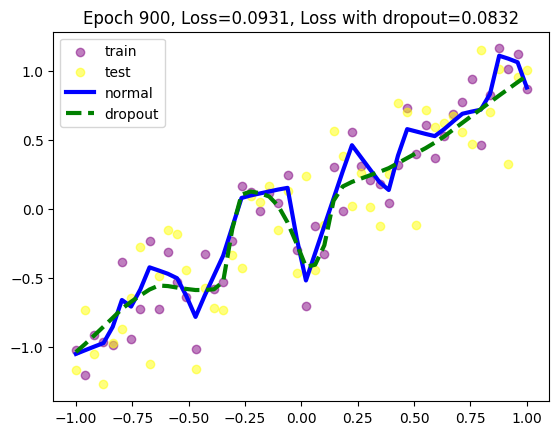

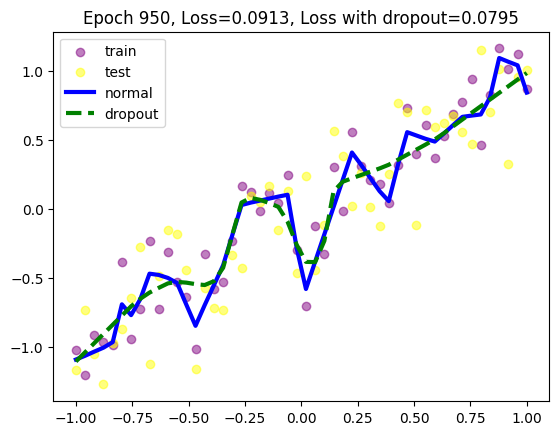

In [44]:
# 모델 학습
max_epochs = 1000
for epoch in range(max_epochs):
    # 드롭아웃이 적용되지 않은 모델 학습
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    # 드롭아웃이 적용된 모델 학습
    pred_dropout = model_dropout(x_train)
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50 == 0:
        model.eval()
        model_dropout.eval()

        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)

        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)

        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        # 파란색 실선
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        # 초록색 점선
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3, label='dropout')
        plt.title(f'Epoch {epoch}, Loss={test_loss:0.4f}, Loss with dropout={test_loss_dropout:0.4f}')
        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)